````{panels} 
:column: col-12
Based on **Hartree-Fock Procedure for Approximate Quantum Chemistry**
Ashley Ringer McDonald  [![Orcid](../../images/orcid.png)](https://orcid.org/0000-0002-4381-1239) Dominic A. Sirianni [![Orcid](../../images/orcid.png)](https://orcid.org/0000-0002-6464-0213) Tricia D. Shepherd [![Orcid](../../images/orcid.png)](https://orcid.org/0000-0001-6512-8951) Sean Garrett-Roe [![Orcid](../../images/orcid.png)](https://orcid.org/0000-0001-6199-8773), 2008-2020, The Psi4Education Developers &nbsp;&nbsp; License BSD-3
````

## Hartree-Fock Procedure for Approximate Quantum Chemistry

In [1]:
import psi4
import numpy as np
from scipy import linalg as splinalg

import sys
sys.path.append("..")
from helpers import *

We learned that we can only solve the Schroedinger equation exactly for one-electron systems. 

To solve many-electron systems we need to use  Hartree-Fock molecular orbital theory. Just as a test case, let's use Psi4 to compute the Hartree-Fock wavefunction and energy for the Hydrogen atom:




In this lab activity, you will build and diagonalize the Fock matrix to determine the MO coefficients and energies for a molecule.  We will be using the functions of the Psi4 quantum chemistry software package to compute the integrals we need.  The following notebook will lead you through setting up your molecule, establishing the basis set, and forming and diagonalizing the Fock matrix.  Be sure to run each cell as your proceed through the notebook.

(hf)=
###  The Hartree-Fock procedure
The Schrödinger equation has the structure of an eigenvalue equation

$$
\hat{H}|\psi\rangle = E|\psi\rangle
$$

In Hartree-Fock theory, this is reexpresed in terms of the Fock matrix, $F$, a matrix of wavefunction amplitudes for each MO, $C$, and the overlap matrix, $S$,

$$
FC = SCE.
$$ (FockMatrix)

The Fock matrix for a closed-shell system is 

$$
F = H + 2J - K
$$

where $H$ is the one electron "core" Hamiltonian, $J$ is the Coulomb integral matrix, and $K$ is the exchange integral matrix. The definitions of $J$ and $K$ depend on the coefficients, $C$. We see here the central premise of SCF:  To get the Fock matrix, we need the coefficient matrix, but to compute the coefficient matrix we need the Fock matrix. When $S$ is not equal to the identity matrix (i.e. the basis is not orthonormal), then this is a pseudo-eigenvalue problem and is even harder to solve. This is our task.


We will
- introduce the overlap matrix 
- learn how to build an orthogonalization matrix
- learn how to calculate the density
- learn how to calculate the Coulomb and Exchange integral matrices
- learn how to diagonalize the Fock matrix
- build an iterative procedure to converge HF energy

It can be helpful to look back at {ref}`exercise1`

### Orthogonalizing the AO basis set

Use the two orthonormal basis vector that we defined in Exercise 1

In [2]:
# define a first basis vector and a second, orthogonal vector (you can use your solutions from Ex 1)
#phi1 = np.array([np.cos(.5), np.sin(.5)]) #insert here
#phi2 = np.array([np.sin(.5), -np.cos(.5)]) #insert here

phi1 = np.array([1/np.sqrt(2), 1/np.sqrt(2)]) 
phi2 = np.array([1/np.sqrt(2), -1/np.sqrt(2)]) 

### IV. The overlap integrals
For a set of basis functions, $\phi_i(\tau)$, where $\tau$ is a shorthand for all the coordinates of all the particles, we can calculate the overlap integrals between the basis functions in the following way

$$S_{ij}=\int {\rm d}\tau\; \phi_i^*(\tau)\phi_j(\tau).$$


:::{admonition} Exercise 1
:class: exercise
Define $S_{ij}$ using Dirac notation.
:::

:::{admonition} Exercise 2
:class: exercise
For an orthonormal basis, what does the overlap integral array, `S`, look like?
:::

Calculate the terms `S_ij` using the basis vectors `phi1` and `phi2`. 

In [3]:
# calculate the overlap (inner product) of the vectors 
S_11 = phi1.conj().dot(phi1) #<your formulas here>
S_12 = phi1.conj().dot(phi2)
S_21 = phi2.conj().dot(phi1)
S_22 = phi2.conj().dot(phi2)
print('The ij elements of S:')
print(S_11,S_12)
print(S_21,S_22)

The ij elements of S:
0.9999999999999998 0.0
0.0 0.9999999999999998


### Constructing the overlap matrix
These overlap integrals, $S_{ij}$, can be interpreted as the elements on the $i$-th row and $j$-th column of a matrix, $S$. Let's propose a matrix, $S$, made of the overlap integrals $S_{ij}$. We can build $S$ systematically in the following way. First, make a matrix, $B$, composed of our basis vectors as columns,

$$ B = \left(\begin{array}{ccc}|& |&|\\ \phi_1 &\phi_2&\phi_3\\|&|&|\end{array}\right).$$

We will use the symbol $\dagger$ to indicate the complex conjugate of the transpose of a matrix. So

$$B^\dagger = (B^T)^*.$$

In [4]:
# construct the overlap matrix from matrix of basis vectors
vector_length = phi1.size #length of the vector space
phi1_column = phi1.reshape(vector_length,1) #this makes phi a column vector
phi2_column = phi2.reshape(vector_length,1)

# put together (concatenate) the vectors into the matrix B
B = np.concatenate((phi1_column,phi2_column),axis=1)
print(F'The matrix B:\n{B}')

B_dagger = B.conj().T
print(F'The matrix B^\\dagger:\n{B_dagger}')

The matrix B:
[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]
The matrix B^\dagger:
[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]


Now, multiplying the rows of $B^\dagger$ by the columns of $B$ (normal matrix multiplication) produces a matrix of the overlap integrals in the correct locations. we defined to be the matrix $S$.

$$B^\dagger B =\left(\begin{array}{ccc}-& \phi_1^*&-\\-& \phi_2^* &-\\-&\phi_3&-\end{array}\right) \left(\begin{array}{ccc}|& |&|\\ \phi_1 &\phi_2&\phi_3\\|&|&|\end{array}\right)\equiv S.$$

:::{margin} Numpy commands for matrix operations
`v` = vector, and `M` = matrix:

matrix vector product: `M.dot(v)`

matrix matrix product: `M.dot(M)`

matrix complex conjugate: `M.conj()`

matrix transpose: `M.T`
:::

:::{admonition} Exercise 3
:class: exercise
 Use `B` and `B_dagger` and the matrix rules above to calculate the matrix `S`.
 :::

In [5]:
# calculate S from matrix of basis vectors
S = B_dagger @ B #<your formula here>
print(F'The matrix of eigenvectors in columns B =\n {B} \n\nand S = B^† B =\n{S}\n')

The matrix of eigenvectors in columns B =
 [[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]] 

and S = B^† B =
[[ 1.00000000e+00 -2.23711432e-17]
 [-2.23711432e-17  1.00000000e+00]]



### Einstein implicit summation notation
Matrix multiplication is defined through

$$(AB)_{pq}= \sum_i A_{p,i}B_{i,q}\qquad\text{explicit summation}$$

Note that there is a repeated index, $i$, in the summation. In implicit summation notation, Einstein notation, we do not write the $\sum$ and treat the summation as understood. 

$$(AB)_{pq}=A_{p,i}B_{i,q}\qquad\text{implicit summation}$$

Using implicit summation for the case at hand, $B^\dagger B$ gives

$$S_{pq}=(B^\dagger B)_{pq}= (B^\dagger)_{p,i}B_{i,q}\qquad\text{implicit summation}$$
$$= (B^*)_{i,p}B_{i,q}\qquad\text{implicit summation}$$

where $B^*$ is the complex conjugate of $B$ (no transpose). Note that the two sets of indices, $(i,p)$ and $(i,q)$, in the input matrices become one set, $(p,q)$, in the product. 

:::{note}
 There is a convenient function in `numpy` called `einsum()`, which is one of the crown jewels of the numpy library.  In short, `einsum` lets you perform various combinations of multiplying, summing, and transposing matrices very efficiently.  [This is a good tutorial](http://ajcr.net/Basic-guide-to-einsum/) about `einsum` if you want to learn more. In this exercise, it suffices to look carefully at the indices of the matrices and use the **Ein**stein **Sum**mation convention.)
 
So in order to calculate the sum 

$$S_{pq} = (B^*)_{i,p}B_{i,q}\qquad\text{implicit summation}$$

use 
```
S=numpy.einsum('ip,iq->pq',B.conj(),B)
```
We will use `einsum()` in several places.
Let's try this with a simple basis set of two (perhaps) orthonormal vectors.
:::

:::{admonition} Exercise 4
:class: exercise
Describe how the notation of the `np.einsum` command correlates to the implicit summation formula written above.
:::

:::{admonition} Exercise 5
:class: exercise
 Use the function `np.einsum()` to calculate the matrix `S`, and confirm that your answer is the same as above.
 :::

In [6]:
# calculate S from Einstein sum
S = np.einsum('ip,iq->pq',B.conj(),B) #<your formula here>
print(F'S from Einstein notation:\n{S}')

S from Einstein notation:
[[1. 0.]
 [0. 1.]]


:::{admonition} Exercise 6
:class: exercise
Propose a different orthonormal basis, modify `phi1` and `phi2`, and verify that `S` still has the same form. There are infinitely many choices. It isn't complex... or *is* it?!
:::

In [7]:
# two orthonormal vectors
phi1 = np.array([np.cos(.5), np.sin(.5)]) #insert here
phi2 = np.array([np.sin(.5), -np.cos(.5)]) #insert here

# construct the overlap matrix from matrix of basis vectors
vector_length = phi1.size #length of the vector space
phi1_column = phi1.reshape(vector_length,1) #this makes phi a column vector
phi2_column = phi2.reshape(vector_length,1)

# put together (concatenate) the vectors into the matrix B
B = np.concatenate((phi1_column,phi2_column),axis=1)
print(F'The matrix B:\n{B}')

B_dagger = B.conj().T
print(F'The matrix B^\\dagger:\n{B_dagger}')

# calculate S from matrix of basis vectors
S = np.einsum('ip,iq->pq',B.conj(),B)
print(F'S from Einstein notation:\n{S}')

The matrix B:
[[ 0.87758256  0.47942554]
 [ 0.47942554 -0.87758256]]
The matrix B^\dagger:
[[ 0.87758256  0.47942554]
 [ 0.47942554 -0.87758256]]
S from Einstein notation:
[[1. 0.]
 [0. 1.]]


### Gaussian atomic orbital basis set

H$_2$O is a small but interesting molecule to use in our exploration. 

:::{admonition} Exercise 7
:class: exercise
How many electrons are there in total in H$_2$O?
How many occupied molecular orbitals would you expect?
:::

Before we can begin to implement the HF procedure, we need to specify the molecule and basis set that we will be using.  We will also set the memory usage for our calcluation and the output file name.  

In [8]:
# ==> Set Basic Psi4 Options <==
# Memory specification
psi4.set_memory('500 MB')
numpy_memory = 2 # No NumPy array can exceed 2 MB in size

# set output file
psi4.core.set_output_file('output.dat', False)

# specify the basis
# basis = 'cc-pvdz'
basis = 'sto-3g'


# Set computation options
psi4.set_options({'basis': basis,
                  'scf_type': 'pk',
                  'e_convergence': 1e-8})


# ==> Define Molecule <==
# Define our model of water
mol = psi4.geometry("""
symmetry c1
O
H 1 1.1
H 1 1.1 2 104
""")

# compute energy

SCF_E_psi = psi4.energy('scf')
psi4.core.clean()

print(f"The Hartree-Fock ground state energy of the water is: {SCF_E_psi} Eh")


  Memory set to 476.837 MiB by Python driver.
The Hartree-Fock ground state energy of the water is: -74.94207989868096 Eh


Next, we need to build the wavefunction from the basis functions.  We store the wavefunction in a variable called `wfn`. We use the function `nalpha()` provided by the wavefunction object we created above, `wfn`, to determine the number of orbitals with spin alpha, which will be doubly occupied orbitals for close shelled systems. We save this answer as a variable called `ndocc` (number of doubly occupied orbitals).  

 Execute the code below and confirm that the number of doubly occupied orbitals matches your expectation for the molecule you chose.

In [9]:
# ==> Compute static 1e- and 2e- quantities with Psi4 <==
wfn = psi4.core.Wavefunction.build(mol, psi4.core.get_global_option('basis'))

# number of spin alpha orbitals (doubly occupied for closed-shell systems)
ndocc = wfn.nalpha()
nbf = wfn.basisset().nbf()

print(F'Number of occupied orbitals: {ndocc}')
print(F'Number of basis functions: {nbf}') 

Number of occupied orbitals: 5
Number of basis functions: 7


Next we will examine the atomic orbital basis set. To do this, we have to set up a data structure, called a class, to calculate the molecular integrals. (Psi4 will do the nasty calculus for us.) We will call this data structure `mints` (Molecular INTegralS). We use the function `ao_overlap` to calculate the overlap integrals between all the AO basis functions.  We cast the result to a numpy array called `S`. 

:::{margin} asarray()
`asarray()` is a special case of `array()` that does not copy arrays when compatible and converts array subclasses to base class ndarrays. [Reference](https://stackoverflow.com/questions/14415741/what-is-the-difference-between-numpys-array-and-asarray-functions)
:::

In [10]:
# Construct a molecular integrals object
mints = psi4.core.MintsHelper(wfn.basisset())

# Overlap matrix as a psi4 Matrix object
S_matrix = mints.ao_overlap()

# Overlap matrix converted into an ndarray
S = np.asarray(S_matrix) 

print(F'Shape of S is {S.shape}')

Shape of S is (7, 7)


:::{admonition} Exercise 8
:class: exercise
 Explain the shape (number of rows and columns) of `S` in terms of the AO basis set we chose.
 :::

Examine the contents of `S`.

In [11]:
print(S) #the full matrix may be somewhat hard to read based on the basis set

[[ 1.00000000e+00  2.36703937e-01 -1.15333163e-18  0.00000000e+00
   0.00000000e+00  3.84055925e-02  3.84055925e-02]
 [ 2.36703937e-01  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  3.86138794e-01  3.86138794e-01]
 [-1.15333163e-18  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  2.09726923e-01  2.09726923e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00 -2.68438220e-01  2.68438220e-01]
 [ 3.84055925e-02  3.86138794e-01  2.09726923e-01  0.00000000e+00
  -2.68438220e-01  1.00000000e+00  1.81759851e-01]
 [ 3.84055925e-02  3.86138794e-01  2.09726923e-01  0.00000000e+00
   2.68438220e-01  1.81759851e-01  1.00000000e+00]]


In [12]:
# Look at the first few elements
peak(S)

Here is a peak at the first 4 x 4 elements of the matrix:
[[ 1.00000000e+00  2.36703937e-01 -1.15333163e-18  0.00000000e+00]
 [ 2.36703937e-01  1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.15333163e-18  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


:::{admonition} Exercise 9
:class: exercise

 Based on your observations of `S` in the AO basis, answer the following questions
1. What do the diagonal elements of `S` indicate?
2. What do the off-diagonal elements of `S` indicate?
3. Does the Gaussian atomic orbital basis set form an orthonormal basis? 

:::

We can perform this test programmatically as well, with a few python tricks. Construct an array of the same size as the overlap array (`S`) that has 1's along the diagonal and 0's everywhere else. Then compare that array to the `S` array to doubly verify whether or not you think the AO basis is orthonormal.

In [13]:
# use some functions from helpers library, you can test your overlap arrays here
isBasisOrthonormal(S)

Q:(T/F) The AO basis is orthonormal? A: False


False

:::{admonition} Exercise 10
:class: exercise
Does the result of your extra evaluation agree with what you determined previously?
:::

### An orthogonalization matrix
Recall that if we had used the hydrogen atom wavefunctions as our basis set, the AO wavefunctions would all be orthonormal. Since we used a basis set of Gaussian wavefuctions, this may not be the case. We will now introduce some tools to fix it!

Since our AO basis set was not orthonormal, we seek to construct an orthogonalization matrix, $A$, such that ${\bf A}^{\dagger}{\bf SA} = {\bf 1}$. 

**Motivation:** If ${\bf A}$ and ${\bf S}$ were real numbers $a$ and $s$ (not matrices), this would be simple to solve. First, $a^\dagger=a$ because a real number is the same as its hermitian transpose. By simple algebra we can solve for a,

$$
a^\dagger s a=1
$$

$$
a^\dagger s a=a s a=a^2s=1
$$

$$
\Rightarrow{}a=s^{-1/2}
$$ 

In linear algebra (with matrices instead of numbers) this is more complicated, but numpy and the mints class can take care of the details for us! Leaving out the details, we will calculate

$$
{\bf A}={\bf S}^{-1/2}
$$

:::{admonition} Exercise 11
:class: exercise
 Use the function `np.linalg.inv()` to calculate the inverse of `S`, and the function `splinalg.sqrtm()` to take its (matrix) square root. Execute the code below and examine the matrix `A`.
 :::

In [14]:
# ==> Construct AO orthogonalization matrix A <==

# inverse of S using np.linalg.inv
# matrix square root of the inverse of S using splinalg.sqrtm

S_inverse = np.linalg.inv(S)

A = splinalg.sqrtm(S_inverse)

A

array([[ 1.02363458e+00, -1.36854677e-01, -7.48725467e-03,
         0.00000000e+00, -1.08457284e-18,  1.90278847e-02,
         1.90278847e-02],
       [-1.36854677e-01,  1.15786316e+00,  7.21600498e-02,
         0.00000000e+00,  3.64651649e-17, -2.22332521e-01,
        -2.22332521e-01],
       [-7.48725467e-03,  7.21600498e-02,  1.03830504e+00,
         0.00000000e+00, -3.75981753e-17, -1.18462545e-01,
        -1.18462545e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-3.45874404e-19,  5.02534544e-17, -4.01081341e-17,
         0.00000000e+00,  1.07331473e+00,  1.75758279e-01,
        -1.75758279e-01],
       [ 1.90278847e-02, -2.22332521e-01, -1.18462545e-01,
         0.00000000e+00,  1.75758279e-01,  1.12972338e+00,
        -6.25974978e-02],
       [ 1.90278847e-02, -2.22332521e-01, -1.18462545e-01,
         0.00000000e+00, -1.75758279e-01, -6.25974978e-02,
         1.1297233

:::{admonition} Exercise 12
:class: exercise
 What do you observe about the elements of `A`? Is the matrix real or complex? Is the matrix symmetric or not?
 :::

Our basis set $B$ is not orthonormal, so we want to take linear combinations of its columns to make a new basis set, $B'$, that is orthonormal. We define a new matrix, $A$, in terms of that transformation,

$$B' = BA.$$

The new overlap matrix will be

\begin{align}
 S' &= B'^\dagger B',\\
 &= (BA)^\dagger (BA),\\
&= A^\dagger B^\dagger BA,\\
&= A^\dagger S A.
\end{align}
The matrix $A$ makes the proper linear combination of the columns of $B$ and $A^\dagger$ makes the linear combinations of the rows of $B^\dagger$. This is a very common structure of transformation matrices. Because $S$ is real and symmetric, $A$ is also real and symmetric, so $A^\dagger=A$. The transformation becomes simply

$$S' = A S A.$$

:::{admonition} Exercise 13
:class: exercise
Use the orthogonalization matrix `A` to transform the overlap matrix, `S`. Check the transformed overlap matrix, `S_p`, to make sure it represents an orthonormal basis.
:::

In [15]:
# Transform S with A and assign the result to S_p

S_p = A.dot(S.dot(A)) #<your equation here>

isBasisOrthonormal(S_p)

Q:(T/F) The AO basis is orthonormal? A: True


True

:::{admonition} Exercise 14
:class: exercise

The product A S A does not take the complex conjugate transpose of A. What conditions (properties of A) make that ok?

:::

### The Fock Matrix Transformed to an Orthonormal Basis
We can now return to Eq. {eq}`FockMatrix` using our orthogonalization matrix $A$. A common linear algebra trick is to "insert one." In this case, the matrix $A$ times its inverse is, by definition the identity matrix, $AA^{-1}={\bf1}$. We can put that factor of one anywhere in an equation that is useful to us, and, then, typically we regroup terms in a way we want. In this case, we insert one  between $FC$ and $SC$.

\begin{align}
FC&=SCE\\
F({\bf1})C&=S({\bf1})CE\\
FAA^{-1}C&=SAA^{-1}CE
\end{align}
Multiplying on the left by $A$ then gives

$$
AFAA^{-1}C=ASAA^{-1}CE
$$

We can recognize the transformation $S'=ASA$ on the right hand side and similarly define $F'=AFA$ on the left hand side. Lastly, we define a transformed coefficient matrix, $C'=A^{-1}C$. Our transformed Fock equation reads

\begin{align}
F'C'&=S'C'E,\\
&=C'E.
\end{align}

The last line follows because $S'={\bf1}$ in our new basis. We now have an eigenvalue problem that we can solve by matrix diagonalization.

In the expression

$$C'=A^{-1}C,$$

the matrix $A^{-1}$ transforms the coefficients, $C$, into the orthogonalized basis set. We will also need a way to transform those coefficients, $C'$, back to the original AO basis.

:::{admonition} Exercise 15
:class: exercise
Based on the definition of $C'$, propose a definition of $C$ in terms of $A$ and $C'$. Justify your equation.
:::

### Initial guess for the Fock Matrix is the one electron Hamiltonian
To get the Fock matrix, we need the coefficient matrix, but to compute the coefficient matrix we need the Fock matrix.  So we start with a guess for the Fock matrix, which is the core Hamiltonian matrix.

In [16]:
# Build core Hamiltonian
T = np.asarray(mints.ao_kinetic())
V = np.asarray(mints.ao_potential())
H = T + V

:::{admonition} Exercise 16
:class: exercise
 In the cell below, use the core Hamiltonian matrix as your initial guess for the Fock matrix. Transform it with the same A matrix you used above.  To calculate the eigenvalues, `vals`, and eigenvectors, `vecs`, of matrix `M` using  `vals, vecs = np.linalg.eigh(M)`.
 :::

In [17]:
# Guess for the Fock matrix
F = H # Replace

# Transformed Fock matrix
F_p =  A.dot(F.dot(A)) # Replace

# Diagonalize F_p for eigenvalues & eigenvectors with NumPy
e, C_p =  np.linalg.eigh(F_p) # Replace

:::{admonition} Exercise 17
:class: exercise
 Display, i.e., `print`, the coefficent matrix and confirm it the correct size
 :::

In [18]:
print(C_p)
print("The size of the coefficient matrix is:",C_p.shape)
print("\n Check that the columns of C_p are indeed eigenvectors:\n",F_p.dot(C_p.T[0].reshape(-1,1))-e[0]*C_p.T[0].reshape(-1,1))
print("\n First eigenvalue is ",e[0])

[[-9.93397459e-01  1.06813566e-01 -1.35307498e-16 -4.17010426e-02
   1.76149298e-15 -3.65697236e-03  1.33010607e-16]
 [-1.14180122e-01 -9.13965568e-01  1.27788258e-15  3.67704764e-01
  -1.55859911e-14  1.28152437e-01 -2.37455910e-15]
 [-7.66151195e-04 -3.68538378e-01 -2.99255600e-15 -9.28905590e-01
   4.00351377e-14  3.62392157e-02 -1.59671447e-15]
 [ 0.00000000e+00 -3.33066907e-16  3.57353036e-16 -4.30211422e-14
  -1.00000000e+00 -3.33066907e-16  5.55111512e-17]
 [ 2.31531739e-18  4.71826794e-17  9.98991226e-01 -3.20984454e-15
   4.77769914e-16 -1.24429917e-15 -4.49058022e-02]
 [-7.86768545e-03 -9.33736227e-02 -3.17531973e-02  9.71167846e-03
  -3.92055707e-16 -7.00803217e-01 -7.06393470e-01]
 [-7.86768545e-03 -9.33736227e-02  3.17531973e-02  9.71167846e-03
   2.74078108e-16 -7.00803217e-01  7.06393470e-01]]
The size of the coefficient matrix is: (7, 7)

 Check that the columns of C_p are indeed eigenvectors:
 [[-7.10542736e-15]
 [-1.33226763e-15]
 [-3.46944695e-18]
 [ 0.00000000e+00]


Now that we have the coefficents in the transformed basis, we need to go back and get the coefficients in the original AO basis.

:::{admonition} Exercise 18
:class: exercise
Use `A` and the formula you proposed previously to transform the coefficient matrix back to the AO basis. Confirm that the resulting matrix appears reasonable, i.e., similar size and magnitude
:::

In [19]:
# Transform the coefficient matrix back into AO basis
C = A.dot(C_p)
print(C)
print("\nThe size of C is :",C.shape)
print("Frobenius norm of C to check magnitude : ||C||_F = Tr[C^† C] =", np.sqrt(np.trace((C.conj().T).dot(C))))

[[-1.00154358e+00  2.33624458e-01 -3.02733347e-16 -8.56842079e-02
   3.63414278e-15 -4.82226017e-02  9.45116473e-16]
 [ 7.18933084e-03 -1.05793876e+00  1.40864302e-15  3.60110465e-01
  -1.53723457e-14  4.63121174e-01 -9.15741996e-15]
 [ 2.67129883e-04 -4.27284243e-01 -3.00096682e-15 -9.39942475e-01
   4.04447865e-14  2.12940092e-01 -5.11420285e-15]
 [ 0.00000000e+00 -3.33066907e-16  3.57353036e-16 -4.30211422e-14
  -1.00000000e+00 -3.33066907e-16  5.55111512e-17]
 [-2.15774773e-17  6.88978035e-17  1.06107023e+00 -3.15567076e-15
   3.95718955e-16 -6.17464044e-15 -2.96507060e-01]
 [-1.82134850e-03  1.49253289e-01  1.37720978e-01  3.78578935e-02
  -1.61997318e-15 -7.80700283e-01 -8.50140251e-01]
 [-1.82134850e-03  1.49253289e-01 -1.37720978e-01  3.78578935e-02
  -9.93671961e-16 -7.80700283e-01  8.50140251e-01]]

The size of C is : (7, 7)
Frobenius norm of C to check magnitude : ||C||_F = Tr[C^† C] = 2.933564513151939


### The Density Matrix
Recall, the Fock matrix is 

$$
F = H + 2J - K
$$

where $H$ is the one electron "core" Hamiltonian, $J$ is the Coulomb integral matrix, and $K$ is the exchange integral matrix. The HF energy can be expressed in explicit terms of one and two electron integrals

$$
E_{HF} = \sum_i^{elec}\langle i|h_i|i\rangle + \sum_{i>j}^{elec}[ii|jj]-[ij|ji]
$$

Expanding the orbitals in terms of basis functions, we find

$$
[ii|jj]=\sum_{pqrs}c^*_{pi}c_{qi}c^*_{rj}c_{sj}\int{\rm d}\tau\; \phi_p^*(1)\phi_q(1)\frac{1}{r_{ij}}\phi_r^*(2)\phi_s(2)
$$ (ColoumbIntegral)


First, look at the coefficients in {eq}`ColoumbIntegral`. They come in two pairs of complex-conjugates, $c^*_{pi}c_{qi}$ and $c^*_{ri}c_{si}$. The diagonal terms, when $p=q$ for example, are the probability of some basis function $p$ contributing to the MO $i$. We will sum each term over the occupied orbitals, $i$, to form the "density matrix"

$$
D_{pq}=\sum_i^{occ} c^*_{pi}c_{qi}.
$$ (DensityMatrix)

We are going to construct the density matrix from the occupied orbitals.  To get a matrix of just the occupied orbitals, use the coefficient matrix in the original AO basis, and take a slice to include all rows and just the columns that represent the occupied orbitals.

In [20]:
# Grab occupied orbitals (recall: ndocc is the number of doubly occupied orbitals we found earlier)
C_occ = C[:, :ndocc]
print(F'The shape of C_occ is {C_occ.shape}')

The shape of C_occ is (7, 5)


:::{admonition} Exercise 19
:class: exercise

 Build the density matrix, `D`, from the occupied orbitals, `C_occ`, using the function `np.einsum()`. **Hint** Look at {eq}`DensityMatrix`
 :::

In [21]:
# Build density matrix from occupied orbitals
D = np.array(np.einsum('pi,qi->pq',C_occ.conj(),C_occ)) # replace this command with np.einsum() as described above
print(F'The shape of D is {D.shape}')

The shape of D is (7, 7)


### Coulomb and Exchange Integrals and the SCF Energy

The integral on the right of {eq}`electronrepuslionintrealtensor` is super important. It has four indicies, $p,q,r,s$, so formally it is a tensor. It accounts for the repulsion between pairs of electrons, so it is called the electron repulsion integral tensor, $I$,

$$
I_{pqrs} = \int{\rm d}\tau\; \phi_p^*(1)\phi_q(1)\frac{1}{r_{ij}}\phi_r^*(2)\phi_s(2).
$$ (electronrepuslionintrealtensor)

First, we can build the electron-repulsion integral (ERI) tensor, which calculates the electron repulsion between the atomic orbital wavefunctions, and the core Hamiltonian. Mints does all the work for us!

In [22]:
# Build electron repulsion integral (ERI) Tensor
I = np.asarray(mints.ao_eri())

{eq}`ColoumbIntegral` can be expressed in terms of $I$ and $D$ as

$$
\begin{align}
[ii|jj] &= \sum_{pqrs}D_{pq}D_{rs}I_{pqrs},\\
&=\sum_{pq}D_{pq}\sum_{rs}D_{rs}I_{pqrs}.
\end{align}
$$

The term $\sum_{rs}D_{rs}I_{pqrs}$ is the effective repulsion felt by one electron due to the other electrons in the system. This term is the Coulomb integral matrix

$$
J_{pq}=\sum_{rs}D_{rs}I_{pqrs}.
$$

:::{admonition} Exercise 20
:class: exercise
Define J  in terms of the density matrix, `D`, and the electron repulsion integral tensor, `I`, using `np.einsum()`. 
:::

In [23]:
#Define J
J = np.einsum('rs,pqrs->pq',D.conj(),I) # use np.einsum here

Similarly, 

$$
\begin{align}
[ij|ji] &= \sum_{pqrs}D_{ps}D_{rq}I_{pqrs},\\
 &= \sum_{ps}D_{ps}\sum_{rq}D_{rq}I_{pqrs}.
\end{align}
$$

corrects the repulsion due to electrons "avoiding each other" due to their Fermionic (antisymmetric w.r.t. exchange) character. This term is the exchange integral matrix

$$
K_{ps}=\sum_{rq}D_{rq}I_{pqrs}.
$$

:::{admonition} Exercise 21
:class: exercise
 Define K  in terms of the density matrix, `D`, and the electron repulsion integral tensor, `I`, using `einsum()`. 
 :::

In [24]:
#Define K
K = np.einsum('rq,pqrs->ps',D.conj(),I) # use np.einsum here

:::{admonition} Exercise 22
:class: exercise

 Define F in terms of H, J, and K. (Recall {ref}`hf`)

 :::

In [25]:
#Define F as a function of H, J, and K
F = H + 2*J - K # insert code here

A more convenient form of the SCF energy is in terms of a sum over the AO basis functions

$$
E = \sum_{pq}(H_{pq} + F_{pq})D_{pq}.
$$

:::{admonition} Exercise 23
:class: exercise
 Calculate the SCF energy based on H, F, and D using `np.einsum()`.
:::

:::{margin} Hint
 The right hand side of the equation is the sum of the product of two terms, each of which has two indices (p and q). The result, E, is a number, so it has no indices. In `einsum()` notation, this case will be represented with the indices for the matrices on the left of the `->`, and no index on the right of the `->`. For example, in the case of just one matrix, the sum of all its elements of a matrix `M` is `sum_of_m = np.einsum('pq->',M )`. In your answer below, be sure to account for any modifications required of an element-wise product of two matrices.
:::

In [26]:
E_nuc = mol.nuclear_repulsion_energy()
SCF_E = E_nuc + np.einsum('pq,pq->',H + F,D) # insert your code here, don't forget to use E_nuc
print(F'Energy = {SCF_E:.8f}')

Energy = -73.28579644


:::{admonition} Exercise 24
:class: exercise
 Based on the result of the calculation in {ref}`basisset`, is this a reasonable answer? 
 :::

:::{admonition} Exercise 25
:class: exercise
 Describe a procedure (i.e. identify the steps) that will update coefficients and compute a new density matrix based on the updated values of the Fock matrix. 
 :::

:::{admonition} Exercise 26
:class: exercise
 Using the procedure proposed above, calculate the updated coefficients
 :::

In [27]:
# insert remaining steps here, you should end with a new C
# transform F to the orthonormal basis
F_p = A.dot(F.dot(A))

# find e and C_p
e, C_p = np.linalg.eigh(F_p)

# find C
C = A.dot(C_p)

# Select the occupied MOs
C_occ = C[:, :ndocc]

# Update the density matrix
D = np.einsum('pi,qi->pq', C_occ, C_occ)

You have just completed one cycle of the SCF calculation!


Now we will use the density matrix to build the Fock matrix.  The code block below sets up a skeleton of the Hartree-Fock procedure.  The basic steps are:
1. Calculate the Fock Matrix based on the density matrix previously defined from a one electron hamiltonian
2. Calculate the energy from the Fock matrix.
3. Check and see if the energy has converged by comparing the current energy to the previous energy and seeing if it is within the convergence threshold.
4. If the energy has not converged, transform the Fock matrix, and diagonalize the transformed Fock matrix to get the energy and MO coefficients.  Then transform back to the original AO basis, pull the occupied orbitals, and reconstruct the density matrix. 

In [28]:
# ==> Nuclear Repulsion Energy <==
E_nuc = mol.nuclear_repulsion_energy()

# ==> SCF Iterations <==
# Pre-iteration energy declarations
SCF_E = 0.0
E_old = 0.0

# ==> Set default program options <==
# We continue recalculating the energy until it converges to the level we specify.  
# The varible `E_conv` is where we set this level of convergence.  We also set a 
# maximum number of iterations so that if our calculation does not converge, it 
# eventually stops and lets us know that it did not converge.  
# Maximum SCF iterations
MAXITER = 40
# Energy convergence criterion
E_conv = 1.0e-6

print('==> Starting SCF Iterations <==\n')

# Begin Iterations
for scf_iter in range(1, MAXITER + 1):
    
    # Build Fock matrix (meaning define J, K with density matrix and then define F with J and k) 
    
    # <your code here>
    J = np.einsum('rs,pqrs->pq',D.conj(),I) 
    K = np.einsum('rq,pqrs->ps',D.conj(),I)
    F = H + 2*J - K
    

    # Compute SCF energy (don't forget E_nuc!)
    
    SCF_E = E_nuc + np.einsum('pq,pq->',H + F,D) #<your formula here>
    
    print(F'SCF Iteration {scf_iter}: Energy = {SCF_E:.8f} dE = {SCF_E - E_old:.8f}')
    
    # Check to see if the energy is converged.  If it is break out of the loop.
    # If it is not, set the current energy E_old
    
    if (abs(SCF_E - E_old) < E_conv):
        break
    E_old = SCF_E
    
    # Compute new coefficient & density matrices (Exercise 26)
    
    # <your code here>  
    F_p = A.dot(F.dot(A))

    # find e and C_p
    e, C_p = np.linalg.eigh(F_p)
    
    # find C
    C = A.dot(C_p)
    
    # Select the occupied MOs
    C_occ = C[:, :ndocc]
    
    # Update the density matrix
    D = np.einsum('pi,qi->pq', C_occ.conj(), C_occ)
    
    # MAXITER exceeded?
    if (scf_iter == MAXITER):
        psi4.core.clean()
        raise Exception("Maximum number of SCF iterations exceeded.")

# Post iterations
print('\nSCF converged.')
print(F'Final RHF Energy: {SCF_E:.6f} [Eh]')

==> Starting SCF Iterations <==

SCF Iteration 1: Energy = -74.82812526 dE = -74.82812526
SCF Iteration 2: Energy = -74.93548796 dE = -0.10736270
SCF Iteration 3: Energy = -74.94147771 dE = -0.00598975
SCF Iteration 4: Energy = -74.94197197 dE = -0.00049425
SCF Iteration 5: Energy = -74.94205603 dE = -0.00008407
SCF Iteration 6: Energy = -74.94207439 dE = -0.00001836
SCF Iteration 7: Energy = -74.94207862 dE = -0.00000423
SCF Iteration 8: Energy = -74.94207960 dE = -0.00000098

SCF converged.
Final RHF Energy: -74.942080 [Eh]


Compare your results to Psi4 by computing the energy using `psi4.energy()` in the cell below.  

In [29]:
# ==> Compare our SCF to Psi4 <==
# Call psi4.energy() to compute the SCF energy
SCF_E_psi = psi4.energy('SCF')
psi4.core.clean()

print(f"PSI4 {SCF_E_psi:.6f}  Ours {SCF_E:.6f}   Absolute difference {np.abs(SCF_E-SCF_E_psi)}")


PSI4 -74.942080  Ours -74.942080   Absolute difference 2.9805295298501733e-07


:::{admonition} Bonus Exercise 27
:class: exercise
Modify the value of E_conv and describe its effect the number of iterations.Provide your code, the output of the SCF calculation and the number of iterations.
:::

In [30]:
# We restart the whole process
# Guess for the Fock matrix
F = H # Replace

# Transformed Fock matrix
F_p =  A.dot(F.dot(A)) # Replace

# Diagonalize F_p for eigenvalues & eigenvectors with NumPy
e, C_p =  np.linalg.eigh(F_p) # Replace

# Retrieve C
C = A.dot(C_p)

C_occ = C[:, :ndocc]

# Build density matrix from occupied orbitals
D = np.array(np.einsum('pi,qi->pq',C_occ.conj(),C_occ))

# Build electron repulsion integral (ERI) Tensor
I = np.asarray(mints.ao_eri())

#Define J
J = np.einsum('rs,pqrs->pq',D.conj(),I) # use np.einsum here

#Define K
K = np.einsum('rq,pqrs->ps',D.conj(),I) # use np.einsum here

#Define F as a function of H, J, and K
F = H + 2*J - K # insert code here

E_nuc = mol.nuclear_repulsion_energy()
SCF_E = E_nuc + np.einsum('pq,pq->',H + F,D)

# insert remaining steps here, you should end with a new C
# transform F to the orthonormal basis
F_p = A.dot(F.dot(A))

# find e and C_p
e, C_p = np.linalg.eigh(F_p)

# find C
C = A.dot(C_p)

# Select the occupied MOs
C_occ = C[:, :ndocc]

# Update the density matrix
D = np.einsum('pi,qi->pq', C_occ, C_occ)

# ==> Nuclear Repulsion Energy <==
E_nuc = mol.nuclear_repulsion_energy()

# ==> SCF Iterations <==
# Pre-iteration energy declarations
SCF_E = 0.0
E_old = 0.0

# ==> Set default program options <==
# We continue recalculating the energy until it converges to the level we specify.  
# The varible `E_conv` is where we set this level of convergence.  We also set a 
# maximum number of iterations so that if our calculation does not converge, it 
# eventually stops and lets us know that it did not converge.  
# Maximum SCF iterations
MAXITER = 40
# Energy convergence criterion
E_conv = 1e-6
# [1e-3, 5e-4, 1e-4, 5e-5, 1e-6, 5e-7, 1e-8, 5e-9, 1e-10, 1e-12]

print('==> Starting SCF Iterations <==\n')

# Begin Iterations
for scf_iter in range(1, MAXITER + 1):
    
    # Build Fock matrix (meaning define J, K with density matrix and then define F with J and k) 
    
    # <your code here>
    J = np.einsum('rs,pqrs->pq',D.conj(),I) 
    K = np.einsum('rq,pqrs->ps',D.conj(),I)
    F = H + 2*J - K
    

    # Compute SCF energy (don't forget E_nuc!)
    
    SCF_E = E_nuc + np.einsum('pq,pq->',H + F,D) #<your formula here>
    
    print(F'SCF Iteration {scf_iter}: Energy = {SCF_E:.8f} dE = {SCF_E - E_old:.8f}')
    
    # Check to see if the energy is converged.  If it is break out of the loop.
    # If it is not, set the current energy E_old
    
    if (abs(SCF_E - E_old) < E_conv):
        break
    E_old = SCF_E
    
    # Compute new coefficient & density matrices (Exercise 26)
    
    # <your code here>  
    F_p = A.dot(F.dot(A))

    # find e and C_p
    e, C_p = np.linalg.eigh(F_p)
    
    # find C
    C = A.dot(C_p)
    
    # Select the occupied MOs
    C_occ = C[:, :ndocc]
    
    # Update the density matrix
    D = np.einsum('pi,qi->pq', C_occ, C_occ)
    
    # MAXITER exceeded?
    if (scf_iter == MAXITER):
        psi4.core.clean()
        raise Exception("Maximum number of SCF iterations exceeded.")

# Post iterations
print('\nSCF converged.')
print(F'Final RHF Energy: {SCF_E:.6f} [Eh]')

# ==> Compare our SCF to Psi4 <==
# Call psi4.energy() to compute the SCF energy
SCF_E_psi = psi4.energy('SCF')
psi4.core.clean()

print(f"PSI4 {SCF_E_psi:.6f}  Ours {SCF_E:.6f}   Absolute difference {np.abs(SCF_E-SCF_E_psi)}")


==> Starting SCF Iterations <==

SCF Iteration 1: Energy = -74.82812526 dE = -74.82812526
SCF Iteration 2: Energy = -74.93548796 dE = -0.10736270
SCF Iteration 3: Energy = -74.94147771 dE = -0.00598975
SCF Iteration 4: Energy = -74.94197197 dE = -0.00049425
SCF Iteration 5: Energy = -74.94205603 dE = -0.00008407
SCF Iteration 6: Energy = -74.94207439 dE = -0.00001836
SCF Iteration 7: Energy = -74.94207862 dE = -0.00000423
SCF Iteration 8: Energy = -74.94207960 dE = -0.00000098

SCF converged.
Final RHF Energy: -74.942080 [Eh]
PSI4 -74.942080  Ours -74.942080   Absolute difference 2.9805295298501733e-07


# We test 10 values of E_conv and its effect on the number of iterations



===== Running SCF with E_conv = 1.0e-03 =====

==> Starting SCF Iterations <==

SCF Iteration 1: Energy = -74.82812526 dE = -74.82812526
SCF Iteration 2: Energy = -74.93548796 dE = -0.10736270
SCF Iteration 3: Energy = -74.94147771 dE = -0.00598975
SCF Iteration 4: Energy = -74.94197197 dE = -0.00049425

SCF converged.
Final RHF Energy: -74.941972 [Eh]
PSI4 -74.942080  Ours -74.941972   Absolute difference 0.00010793216969773312


===== Running SCF with E_conv = 5.0e-04 =====

==> Starting SCF Iterations <==

SCF Iteration 1: Energy = -74.82812526 dE = -74.82812526
SCF Iteration 2: Energy = -74.93548796 dE = -0.10736270
SCF Iteration 3: Energy = -74.94147771 dE = -0.00598975
SCF Iteration 4: Energy = -74.94197197 dE = -0.00049425

SCF converged.
Final RHF Energy: -74.941972 [Eh]
PSI4 -74.942080  Ours -74.941972   Absolute difference 0.00010793216969773312


===== Running SCF with E_conv = 1.0e-04 =====

==> Starting SCF Iterations <==

SCF Iteration 1: Energy = -74.82812526 dE = -74.

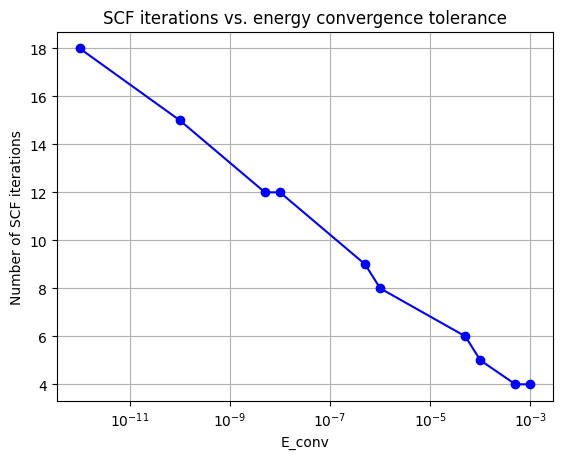

In [31]:
import numpy as np
import matplotlib.pyplot as plt

E_conv_values = [1e-3, 5e-4, 1e-4, 5e-5, 1e-6, 5e-7, 1e-8, 5e-9, 1e-10, 1e-12]

iterations_per_econv = []

for E_conv in E_conv_values:
    print(f"\n\n===== Running SCF with E_conv = {E_conv:.1e} =====\n")

    # We restart the whole process for each E_conv
    # Guess for the Fock matrix
    F = H # Replace

    # Transformed Fock matrix
    F_p =  A.dot(F.dot(A)) # Replace

    # Diagonalize F_p for eigenvalues & eigenvectors with NumPy
    e, C_p =  np.linalg.eigh(F_p) # Replace

    # Retrieve C
    C = A.dot(C_p)

    C_occ = C[:, :ndocc]

    # Build density matrix from occupied orbitals
    D = np.array(np.einsum('pi,qi->pq',C_occ.conj(),C_occ))

    # Build electron repulsion integral (ERI) Tensor
    I = np.asarray(mints.ao_eri())

    #Define J
    J = np.einsum('rs,pqrs->pq',D.conj(),I) # use np.einsum here

    #Define K
    K = np.einsum('rq,pqrs->ps',D.conj(),I) # use np.einsum here

    #Define F as a function of H, J, and K
    F = H + 2*J - K # insert code here

    E_nuc = mol.nuclear_repulsion_energy()
    SCF_E = E_nuc + np.einsum('pq,pq->',H + F,D)

    # insert remaining steps here, you should end with a new C
    # transform F to the orthonormal basis
    F_p = A.dot(F.dot(A))

    # find e and C_p
    e, C_p = np.linalg.eigh(F_p)

    # find C
    C = A.dot(C_p)

    # Select the occupied MOs
    C_occ = C[:, :ndocc]

    # Update the density matrix
    D = np.einsum('pi,qi->pq', C_occ.conj(), C_occ)

    # ==> Nuclear Repulsion Energy <==
    E_nuc = mol.nuclear_repulsion_energy()

    # ==> SCF Iterations <==
    # Pre-iteration energy declarations
    SCF_E = 0.0
    E_old = 0.0

    # ==> Set default program options <==
    # Maximum SCF iterations
    MAXITER = 40
    # Energy convergence criterion comes from the loop variable E_conv

    print('==> Starting SCF Iterations <==\n')

    # Begin Iterations
    for scf_iter in range(1, MAXITER + 1):
        
        # Build Fock matrix
        J = np.einsum('rs,pqrs->pq',D.conj(),I) 
        K = np.einsum('rq,pqrs->ps',D.conj(),I)
        F = H + 2*J - K
        
        # Compute SCF energy (don't forget E_nuc!)
        SCF_E = E_nuc + np.einsum('pq,pq->',H + F,D)
        
        print(F'SCF Iteration {scf_iter}: Energy = {SCF_E:.8f} dE = {SCF_E - E_old:.8f}')
        
        # Convergence check
        if (abs(SCF_E - E_old) < E_conv):
            iter_count = scf_iter  # record how many iterations this run took
            break
        E_old = SCF_E
        
        # New coefficients & density
        F_p = A.dot(F.dot(A))
        e, C_p = np.linalg.eigh(F_p)
        C = A.dot(C_p)
        C_occ = C[:, :ndocc]
        D = np.einsum('pi,qi->pq', C_occ.conj(), C_occ)
        
        # MAXITER exceeded?
        if (scf_iter == MAXITER):
            psi4.core.clean()
            raise Exception("Maximum number of SCF iterations exceeded.")

    # Post iterations
    print('\nSCF converged.')
    print(F'Final RHF Energy: {SCF_E:.6f} [Eh]')

    # ==> Compare our SCF to Psi4 <==
    SCF_E_psi = psi4.energy('SCF')
    psi4.core.clean()
    print(f"PSI4 {SCF_E_psi:.6f}  Ours {SCF_E:.6f}   Absolute difference {np.abs(SCF_E-SCF_E_psi)}")

    # Save iterations for this tolerance
    iterations_per_econv.append(iter_count)

# === Plot: iterations as a function of E_conv ===
plt.figure()
plt.plot(E_conv_values, iterations_per_econv, marker='o', color ="b")
plt.xscale('log')
plt.xlabel('E_conv')
plt.ylabel('Number of SCF iterations')
plt.title('SCF iterations vs. energy convergence tolerance')
plt.grid(True)
plt.show()


# We track iterations and absolute error as a function of $E_{conv}$



===== Running SCF with E_conv = 1.0e-03 =====

==> Starting SCF Iterations <==

SCF Iteration 1: Energy = -74.82812526 dE = -74.82812526
SCF Iteration 2: Energy = -74.93548796 dE = -0.10736270
SCF Iteration 3: Energy = -74.94147771 dE = -0.00598975
SCF Iteration 4: Energy = -74.94197197 dE = -0.00049425

SCF converged.
Final RHF Energy: -74.941972 [Eh]
PSI4 -74.942080  Ours -74.941972   Absolute difference 0.00010793216969773312


===== Running SCF with E_conv = 5.0e-04 =====

==> Starting SCF Iterations <==

SCF Iteration 1: Energy = -74.82812526 dE = -74.82812526
SCF Iteration 2: Energy = -74.93548796 dE = -0.10736270
SCF Iteration 3: Energy = -74.94147771 dE = -0.00598975
SCF Iteration 4: Energy = -74.94197197 dE = -0.00049425

SCF converged.
Final RHF Energy: -74.941972 [Eh]
PSI4 -74.942080  Ours -74.941972   Absolute difference 0.00010793216969773312


===== Running SCF with E_conv = 1.0e-04 =====

==> Starting SCF Iterations <==

SCF Iteration 1: Energy = -74.82812526 dE = -74.

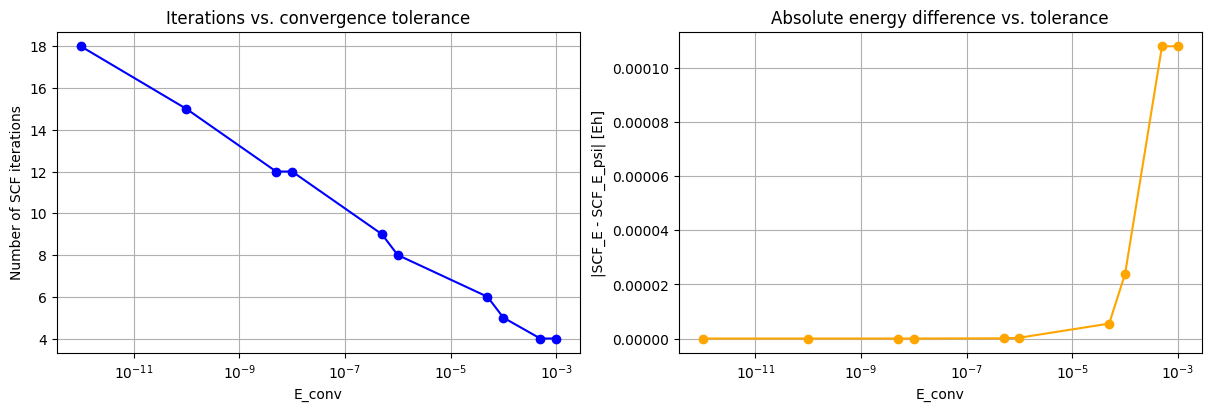

In [32]:
E_conv_values = [1e-3, 5e-4, 1e-4, 5e-5, 1e-6, 5e-7, 1e-8, 5e-9, 1e-10, 1e-12]

iterations_per_econv = []
abs_diffs_per_econv = [] 

for E_conv in E_conv_values:
    print(f"\n\n===== Running SCF with E_conv = {E_conv:.1e} =====\n")

    # We restart the whole process
    # Guess for the Fock matrix
    F = H # Replace

    # Transformed Fock matrix
    F_p =  A.dot(F.dot(A)) # Replace

    # Diagonalize F_p for eigenvalues & eigenvectors with NumPy
    e, C_p =  np.linalg.eigh(F_p) # Replace

    # Retrieve C
    C = A.dot(C_p)

    C_occ = C[:, :ndocc]

    # Build density matrix from occupied orbitals
    D = np.array(np.einsum('pi,qi->pq',C_occ.conj(),C_occ))

    # Build electron repulsion integral (ERI) Tensor
    I = np.asarray(mints.ao_eri())

    #Define J
    J = np.einsum('rs,pqrs->pq',D.conj(),I) # use np.einsum here

    #Define K
    K = np.einsum('rq,pqrs->ps',D.conj(),I) # use np.einsum here

    #Define F as a function of H, J, and K
    F = H + 2*J - K # insert code here

    E_nuc = mol.nuclear_repulsion_energy()
    SCF_E = E_nuc + np.einsum('pq,pq->',H + F,D)

    # insert remaining steps here, you should end with a new C
    # transform F to the orthonormal basis
    F_p = A.dot(F.dot(A))

    # find e and C_p
    e, C_p = np.linalg.eigh(F_p)

    # find C
    C = A.dot(C_p)

    # Select the occupied MOs
    C_occ = C[:, :ndocc]

    # Update the density matrix
    D = np.einsum('pi,qi->pq', C_occ.conj(), C_occ)

    # ==> Nuclear Repulsion Energy <==
    E_nuc = mol.nuclear_repulsion_energy()

    # ==> SCF Iterations <==
    # Pre-iteration energy declarations
    SCF_E = 0.0
    E_old = 0.0

    # ==> Set default program options <==
    # Maximum SCF iterations
    MAXITER = 40
    # Energy convergence criterion comes from the loop variable E_conv

    print('==> Starting SCF Iterations <==\n')

    # Begin Iterations
    for scf_iter in range(1, MAXITER + 1):
        
        # Build Fock matrix
        J = np.einsum('rs,pqrs->pq',D.conj(),I) 
        K = np.einsum('rq,pqrs->ps',D.conj(),I)
        F = H + 2*J - K
        
        # Compute SCF energy (don't forget E_nuc!)
        SCF_E = E_nuc + np.einsum('pq,pq->',H + F,D)
        
        print(F'SCF Iteration {scf_iter}: Energy = {SCF_E:.8f} dE = {SCF_E - E_old:.8f}')
        
        # Convergence check
        if (abs(SCF_E - E_old) < E_conv):
            iter_count = scf_iter 
            break
        E_old = SCF_E
        
        # New coefficients & density
        F_p = A.dot(F.dot(A))
        e, C_p = np.linalg.eigh(F_p)
        C = A.dot(C_p)
        C_occ = C[:, :ndocc]
        D = np.einsum('pi,qi->pq', C_occ.conj(), C_occ)
        
        # MAXITER exceeded?
        if (scf_iter == MAXITER):
            psi4.core.clean()
            raise Exception("Maximum number of SCF iterations exceeded.")

    # Post iterations
    print('\nSCF converged.')
    print(F'Final RHF Energy: {SCF_E:.6f} [Eh]')

    # ==> Compare our SCF to Psi4 <==
    SCF_E_psi = psi4.energy('SCF')
    psi4.core.clean()
    abs_diff = np.abs(SCF_E - SCF_E_psi)   # <— NEW: absolute difference
    print(f"PSI4 {SCF_E_psi:.6f}  Ours {SCF_E:.6f}   Absolute difference {abs_diff}")

    # Save metrics for this tolerance
    iterations_per_econv.append(iter_count)
    abs_diffs_per_econv.append(abs_diff)

# === Plots: side-by-side ===
fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

# Left: iterations vs E_conv
axes[0].plot(E_conv_values, iterations_per_econv, marker='o', color ="b")
axes[0].set_xscale('log')
axes[0].set_xlabel('E_conv')
axes[0].set_ylabel('Number of SCF iterations')
axes[0].set_title('Iterations vs. convergence tolerance')
axes[0].grid(True)

# Right: |SCF_E - SCF_E_psi| vs E_conv
axes[1].plot(E_conv_values, abs_diffs_per_econv, marker='o',color ="orange")
axes[1].set_xscale('log')
axes[1].set_xlabel('E_conv')
axes[1].set_ylabel('|SCF_E - SCF_E_psi| [Eh]')
axes[1].set_title('Absolute energy difference vs. tolerance')
axes[1].grid(True)

plt.show()
